In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [2]:
df = pd.read_csv("/mnt/data/ML-Ready/mixed_data/outputs/best_val_loss_res.csv")

In [3]:
df2 = pd.read_csv("/mnt/data/ML-Ready/mixed_data/outputs/deep-vit-weighted.csv")

In [ ]:
df3 = pd.read_csv("/mnt/data/ML-Ready/flares_event_dir/outputs/testing.csv")

In [ ]:
print(df.head())

In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format='%Y-%m-%dT%H:%M:%S')
# df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [ ]:
plt.style.use('dark_background')
sns.set_palette("husl")

df = df.sort_values(by='Timestamp')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')
plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR - MEGS', marker='o',markersize=4,alpha=.75,c='skyblue')
plt.plot(df2['Timestamp'], df2['Predictions'], label='Predicted SXR - Deep-ViT', marker='o',markersize=4,alpha=.75,c='orange')
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=4,alpha=.75,c='red')
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-07T00:00:00"), pd.to_datetime("2023-08-9T00:00:00"))

plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sort dataframes by timestamp
df = df.sort_values(by='Timestamp')
df2 = df2.sort_values(by='Timestamp')

# Create the interactive plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=df['Timestamp'],
    y=df['Predictions'],
    mode='lines+markers',
    name='Predicted SXR - MEGS',
    line=dict(color='skyblue'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>MEGS Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df2['Timestamp'],
    y=df2['Predictions'],
    mode='lines+markers',
    name='Predicted SXR - Deep-ViT',
    line=dict(color='orange'),
    marker=dict(size=4, opacity=0.75),
    hovertemplate='<b>Deep-ViT Prediction</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=df['Timestamp'],
    y=df['ground_truth'],
    mode='lines+markers',
    name='Ground Truth SXR',
    line=dict(color='red'),
    marker=dict(symbol='x', size=4, opacity=0.75),
    hovertemplate='<b>Ground Truth</b><br>Time: %{x}<br>SXR: %{y:.2e} W/m²<extra></extra>'
))

# Update layout with dark theme
fig.update_layout(
    width=1600,  # Width in pixels
    height=800,
    title={
        'text': 'SXR Prediction vs Ground Truth (Interactive)',
        'x': 0.5,
        'font': {'size': 16, 'color': 'white'}
    },
    xaxis_title="Timestamp",
    yaxis_title="SXR Value (W/m²)",
    xaxis=dict(
        range=[pd.to_datetime("2023-08-07T00:00:00"), pd.to_datetime("2023-08-09T00:00:00")],
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    yaxis=dict(
        type='log',
        color='white',
        gridcolor='rgba(255,255,255,0.2)',
        showgrid=True
    ),
    plot_bgcolor='#2d2d44',
    paper_bgcolor='#1a1a2e',
    font=dict(color='white'),
    legend=dict(
        bgcolor='rgba(0,0,0,0.5)',
        bordercolor='white',
        borderwidth=1
    )
)

# Enable range slider and range selector for easy time navigation
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1h", step="hour", stepmode="backward"),
                dict(count=6, label="6h", step="hour", stepmode="backward"),
                dict(count=12, label="12h", step="hour", stepmode="backward"),
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
    )
)

# Show the plot
fig.show()

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm, LogNorm
from sunpy.visualization.colormaps import color_tables as ct
from scipy.ndimage import zoom


def load_aia_image(timestamp, aia_dir):
    """Load AIA image for given timestamp"""
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    print(f"Found {len(files)} files matching pattern: {pattern}")
    if files:
        aia_data = np.load(files[0])  # Expected shape: (6, 512, 512)
        return aia_data
    return None

def load_attention_map(timestamp, weight_path):
    """Load attention map for given timestamp"""
    filepath = f"{weight_path}{timestamp}"
    try:
        attention_map = np.loadtxt(filepath, delimiter=",")
        return attention_map
    except Exception as e:
        print(f"Failed to load attention map from {filepath}: {e}")
        return None

def display_images_for_timestamp(timestamp, aia_dir, weight_path):
    """Load and display AIA images with attention heatmap and contours"""
    print(f"\nLoading images for timestamp: {timestamp}")

    aia_data = load_aia_image(timestamp, aia_dir)
    attention_data = load_attention_map(timestamp, weight_path)
    attention_data = zoom(attention_data, (8, 8), order=1)

    if aia_data is None:
        print(f"Could not load AIA image for {timestamp}")
        return
    if attention_data is None:
        print(f"Could not load attention map for {timestamp}")
        return

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']

    #att_vmin = np.percentile(attention_data, 2)
    #att_vmax = np.percentile(attention_data, 98)
    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]

        aia_img = aia_data[i]

        # Plot AIA image
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        #Overlay attention heatmap with AsinhNorm
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm, interpolation='nearest')

        # # Overlay contours
        cont = ax.contour(attention_data, levels=10, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')

        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
display_images_for_timestamp("2023-08-07T00:00:00","/mnt/data/ML-Ready/mixed_data/AIA/test/","/mnt/data/ML-Ready/mixed_data/weights2/")

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio


# Config
aia_dir = "/mnt/data/ML-Ready/mixed_data/AIA/test/" # <-- replace with your actual AIA .npy directory
weight_path = "/mnt/data/ML-Ready/mixed_data/weights/"  # <-- replace with your attention map dir
output_dir = "/mnt/data/ML-Ready/mixed_data/movie/"
output_video = "aia_attention_movie.mp4"
os.makedirs(output_dir, exist_ok=True)

# Generate timestamps (30 min intervals from Aug 1 to Aug 14)
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=30)
timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# Visualization and saving function
def load_aia_image(timestamp):
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    if files:
        return np.load(files[0])
    return None

def load_attention_map(timestamp):
    filepath = f"{weight_path}{timestamp}"
    try:
        return np.loadtxt(filepath, delimiter=",")
    except:
        return None

def generate_frame(timestamp, save_path):
    aia_data = load_aia_image(timestamp)
    attention_data = load_attention_map(timestamp)
    attention_data = zoom(attention_data, (8, 8), order=1)
    if aia_data is None or attention_data is None:
        return False  # skip if either is missing

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')
    wavs = ['94', '131', '171', '193', '211', '304']


    att_norm = AsinhNorm()

    for i in range(6):
        row, col = divmod(i, 3)
        ax = axs[row, col]
        aia_img = aia_data[i]
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm)
        cont = ax.contour(attention_data, levels=7, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(f'Timestamp: {timestamp}', color='white', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.close()
    return True

# Create all frames
frame_paths = []
for timestamp in timestamps:
    print(f"Generating frame for {timestamp}...")
    frame_path = os.path.join(output_dir, f"{timestamp}.png")
    success = generate_frame(timestamp, frame_path)
    if success:
        frame_paths.append(frame_path)
    else:
        print(f"Skipped {timestamp} (missing data)")

# Compile into video
with imageio.get_writer(output_video, fps=30) as writer:  # You can adjust fps
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"✅ Movie saved to: {output_video}")

In [ ]:
import os
import glob
import numpy as np
import matplotlib
matplotlib.use('Agg')  # headless backend
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio
from concurrent.futures import ProcessPoolExecutor


# === Register colormaps === #


# === Config === #
AIA_DIR = "/mnt/data/ML-Ready/mixed_data/AIA/test/"
WEIGHT_PATH = "/mnt/data/ML-Ready/mixed_data/weights/"
OUTPUT_DIR = "/mnt/data/ML-Ready/mixed_data/movie/"
OUTPUT_VIDEO = os.path.join(OUTPUT_DIR, "aia_attention_movie.mp4")
os.makedirs(OUTPUT_DIR, exist_ok=True)

WAV_CHANNELS = ['94', '131', '171', '193', '211', '304']

# === Timestamps === #
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=5)

timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# === Determine attention map normalization === #
sample_map = None
for ts in timestamps:
    try:
        sample_map = np.loadtxt(os.path.join(WEIGHT_PATH, ts), delimiter=",")
        break
    except:
        continue

if sample_map is None:
    raise RuntimeError("No valid attention map found.")

ATT_VMIN = np.percentile(sample_map, 2)
ATT_VMAX = np.percentile(sample_map, 98)
ATT_NORM = AsinhNorm(vmin=ATT_VMIN, vmax=ATT_VMAX)


# === Frame Generator (must be top-level for multiprocessing) === #
def generate_frame(timestamp):
    # Re-register colormaps in each process


    aia_pattern = f"{AIA_DIR}/*{timestamp}*"
    aia_files = glob.glob(aia_pattern)
    if not aia_files:
        return None

    try:
        aia_data = np.load(aia_files[0])
        attn_path = os.path.join(WEIGHT_PATH, timestamp)
        attn = np.loadtxt(attn_path, delimiter=",")
    except Exception as e:
        print(f"⚠️ Skipping {timestamp}: {e}")
        return None

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.patch.set_facecolor('#1a1a2e')

    for i in range(6):
        ax = axs[i // 3, i % 3]
        ax.imshow(aia_data[i], cmap=f'sdoaia{WAV_CHANNELS[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attn, cmap='hot', origin='lower', alpha=0.25, norm=ATT_NORM)
        cont = ax.contour(attn, levels=7, colors='red', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f"AIA {WAV_CHANNELS[i]} Å", fontsize=10, color='white')
        ax.axis('off')

    plt.suptitle(timestamp, color='white', fontsize=14)
    plt.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, f"{timestamp}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()
    return out_path


# === Run Multiprocessing === #
if __name__ == '__main__':
    print("🚀 Generating frames...")
    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(generate_frame, timestamps))

    # Filter successful frames
    frame_paths = [r for r in results if r is not None]

    print(f"🎞️ Writing video with {len(frame_paths)} frames...")
    with imageio.get_writer(OUTPUT_VIDEO, fps=5, codec='libx264', format='FFMPEG') as writer:
        for path in frame_paths:
            writer.append_data(imageio.imread(path))

    print(f"✅ Done. Movie saved at: {OUTPUT_VIDEO}")


Loading SXR data...
                 Timestamp  Predictions  ground_truth
0      2023-08-01T00:00:00     0.000004  3.441241e-06
1      2023-08-01T00:01:00     0.000005  3.436694e-06
2      2023-08-01T00:02:00     0.000005  3.422183e-06
3      2023-08-01T00:03:00     0.000005  3.407998e-06
4      2023-08-01T00:04:00     0.000005  3.379493e-06
...                    ...          ...           ...
17357  2023-08-13T01:17:00     0.000001  8.526146e-07
17358  2023-08-13T01:18:00     0.000001  8.504726e-07
17359  2023-08-13T01:19:00     0.000001  8.476219e-07
17360  2023-08-13T01:20:00     0.000001  8.457106e-07
17361  2023-08-13T01:21:00     0.000001  8.480510e-07

[17362 rows x 3 columns]
Loaded SXR data with 17362 records
Generating frame for 2023-08-07T00:00:00...


/tmp/ipykernel_2417159/2237782077.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

KeyboardInterrupt


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f8be8971630> (for post_execute), with arguments args (),kwargs {}:


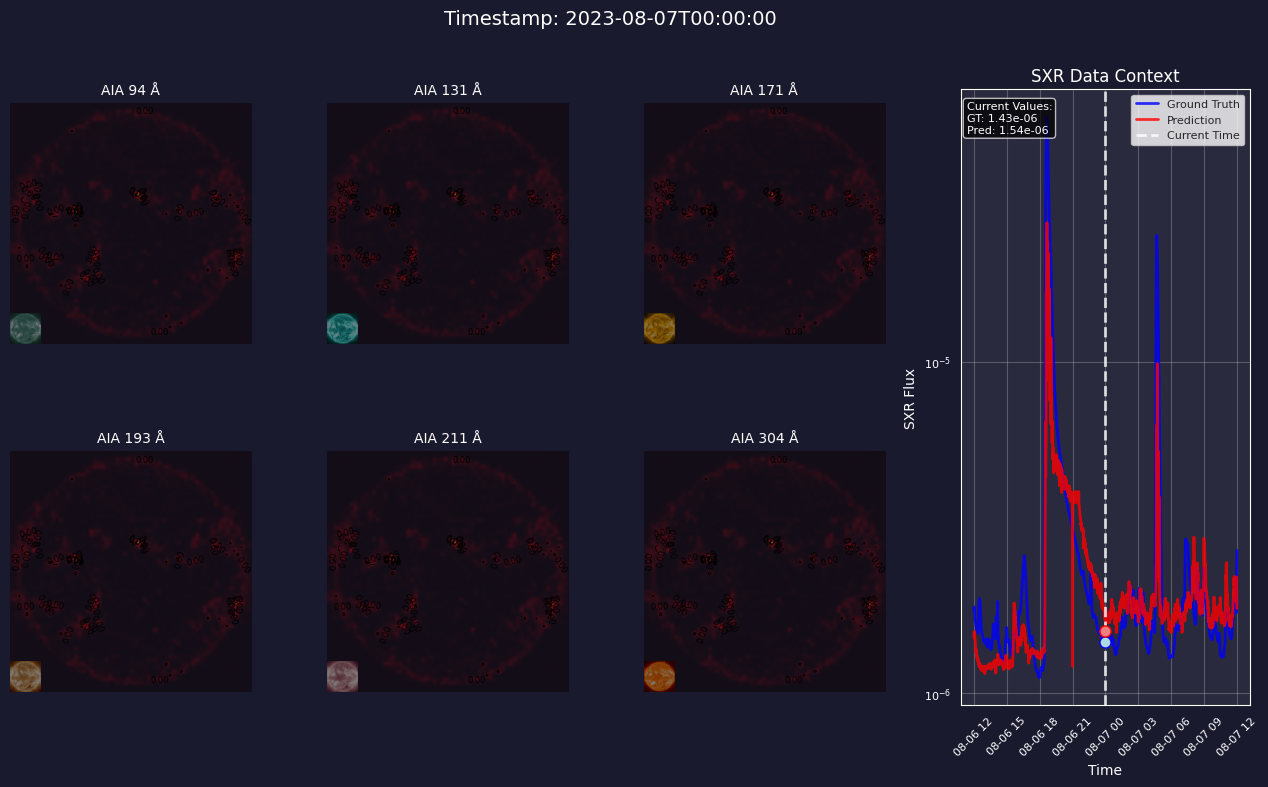

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import AsinhNorm
from sunpy.visualization.colormaps import color_tables as ct
from datetime import datetime, timedelta
import imageio.v2 as imageio
import pandas as pd
from scipy.ndimage import zoom

# Config
aia_dir = "/mnt/data/ML-Ready/mixed_data/AIA/test/" # <-- replace with your actual AIA .npy directory
weight_path = "/mnt/data/ML-Ready/mixed_data/weights/"  # <-- replace with your attention map dir
sxr_data_path = "/mnt/data/ML-Ready/mixed_data/outputs/deep-vit.csv"  # <-- replace with your SXR data file
output_dir = "/mnt/data/ML-Ready/mixed_data/movie/"
output_video = "aia_attention_sxr_movie.mp4"
os.makedirs(output_dir, exist_ok=True)

# Load SXR data at the beginning
print("Loading SXR data...")
try:
    # Assuming CSV with columns: timestamp, prediction, groundtruth
    # Adjust column names as needed for your data format
    sxr_df = pd.read_csv(sxr_data_path)
    print(sxr_df)
    sxr_df['Timestamp'] = pd.to_datetime(sxr_df['Timestamp'])
    print(f"Loaded SXR data with {len(sxr_df)} records")
except Exception as e:
    print(f"Warning: Could not load SXR data: {e}")
    sxr_df = None

# Generate timestamps (30 min intervals from Aug 1 to Aug 14)
start_time = datetime(2023, 8, 7)
end_time = datetime(2023, 8, 9)
interval = timedelta(minutes=30)
timestamps = []
while start_time <= end_time:
    timestamps.append(start_time.strftime("%Y-%m-%dT%H:%M:%S"))
    start_time += interval

# Visualization and saving function
def load_aia_image(timestamp):
    pattern = f"{aia_dir}/*{timestamp}*"
    files = glob.glob(pattern)
    if files:
        return np.load(files[0])
    return None

def load_attention_map(timestamp):
    filepath = f"{weight_path}{timestamp}"
    try:
        return np.loadtxt(filepath, delimiter=",")
    except:
        return None

def get_sxr_data_for_timestamp(timestamp, sxr_df, window_hours=12):
    """Get SXR data around the given timestamp for plotting context"""
    if sxr_df is None:
        return None, None, None

    target_time = pd.to_datetime(timestamp)

    # Get data within the time window around current timestamp
    time_start = target_time - timedelta(hours=window_hours)
    time_end = target_time + timedelta(hours=window_hours)

    mask = (sxr_df['Timestamp'] >= time_start) & (sxr_df['Timestamp'] <= time_end)
    window_data = sxr_df[mask].copy()

    if window_data.empty:
        return None, None, None

    # Find the closest data point to current timestamp
    current_idx = (window_data['Timestamp'] - target_time).abs().idxmin()
    current_data = sxr_df.loc[current_idx]

    return window_data, current_data, target_time

def generate_frame(timestamp, save_path):
    aia_data = load_aia_image(timestamp)
    attention_data = load_attention_map(timestamp)

    if attention_data is not None:
        attention_data = zoom(attention_data, (8, 8), order=1)

    if aia_data is None or attention_data is None:
        return False  # skip if either is missing

    # Get SXR data for this timestamp
    sxr_window, sxr_current, target_time = get_sxr_data_for_timestamp(timestamp, sxr_df)

    # Create figure with adjusted layout for SXR panel
    fig = plt.figure(figsize=(16, 8))
    fig.patch.set_facecolor('#1a1a2e')

    # Create grid layout: 2x3 for AIA images, 1x1 for SXR plot
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1.2], hspace=0.3, wspace=0.3)

    wavs = ['94', '131', '171', '193', '211', '304']
    att_norm = AsinhNorm()

    # Plot AIA images with attention maps (first 3 columns)
    for i in range(6):
        row = i // 3
        col = i % 3
        ax = fig.add_subplot(gs[row, col])

        aia_img = aia_data[i]
        ax.imshow(aia_img, cmap=f'sdoaia{wavs[i]}', origin='lower', norm=AsinhNorm())
        ax.imshow(attention_data, cmap='hot', origin='lower', alpha=0.5, norm=att_norm)
        cont = ax.contour(attention_data, levels=7, colors='black', linewidths=0.7)
        ax.clabel(cont, inline=True, fontsize=6, fmt='%.2f')
        ax.set_title(f'AIA {wavs[i]} Å', fontsize=10, color='white')
        ax.axis('off')

    # Plot SXR data (4th column, spanning both rows)
    sxr_ax = fig.add_subplot(gs[:, 3])
    sxr_ax.set_facecolor('#2a2a3e')

    if sxr_window is not None and not sxr_window.empty:
        # Plot time series
        sxr_ax.plot(sxr_window['Timestamp'], sxr_window['ground_truth'],
                   'b-', label='Ground Truth', linewidth=2, alpha=0.8)
        sxr_ax.plot(sxr_window['Timestamp'], sxr_window['Predictions'],
                   'r-', label='Prediction', linewidth=2, alpha=0.8)

        # Highlight current time point
        if sxr_current is not None:
            sxr_ax.axvline(target_time, color='white', linestyle='--',
                          linewidth=2, alpha=0.8, label='Current Time')
            # Add current values as points
            sxr_ax.plot(target_time, sxr_current['ground_truth'],
                       'bo', markersize=8, markerfacecolor='lightblue')
            sxr_ax.plot(target_time, sxr_current['Predictions'],
                       'ro', markersize=8, markerfacecolor='lightcoral')

        sxr_ax.set_ylabel('SXR Flux', fontsize=10, color='white')
        sxr_ax.set_xlabel('Time', fontsize=10, color='white')
        sxr_ax.set_title('SXR Data Context', fontsize=12, color='white')
        sxr_ax.legend(fontsize=8, loc='upper right')
        sxr_ax.grid(True, alpha=0.3)

        # Format x-axis
        sxr_ax.tick_params(axis='x', rotation=45, labelsize=8, colors='white')
        sxr_ax.tick_params(axis='y', labelsize=8, colors='white')

        # Set y-axis to log scale if dealing with solar flare data
        sxr_ax.set_yscale('log')

        # Add current values as text
        if sxr_current is not None:
            info_text = f"Current Values:\nGT: {sxr_current['ground_truth']:.2e}\nPred: {sxr_current['Predictions']:.2e}"
            sxr_ax.text(0.02, 0.98, info_text, transform=sxr_ax.transAxes,
                       fontsize=8, color='white', verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    else:
        sxr_ax.text(0.5, 0.5, 'No SXR Data\nAvailable',
                   transform=sxr_ax.transAxes, fontsize=12, color='white',
                   horizontalalignment='center', verticalalignment='center')
        sxr_ax.set_title('SXR Data Context', fontsize=12, color='white')

    # Make SXR plot background consistent
    for spine in sxr_ax.spines.values():
        spine.set_color('white')

    plt.suptitle(f'Timestamp: {timestamp}', color='white', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, facecolor='#1a1a2e')
    plt.close()
    return True

# Create all frames
frame_paths = []
for timestamp in timestamps:
    print(f"Generating frame for {timestamp}...")
    frame_path = os.path.join(output_dir, f"{timestamp}.png")
    success = generate_frame(timestamp, frame_path)
    if success:
        frame_paths.append(frame_path)
    else:
        print(f"Skipped {timestamp} (missing data)")

# Compile into video
print("Creating movie...")
with imageio.get_writer(output_video, fps=30) as writer:  # You can adjust fps
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"✅ Movie saved to: {output_video}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

# Set style
plt.style.use('dark_background')
sns.set_palette("husl")

# Ensure df is sorted by timestamp
df = df.sort_values(by='Timestamp')

# Convert timestamps to datetime if they aren't already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Define date range for the animation
start_date = pd.to_datetime("2023-08-01T00:00:00")
end_date = pd.to_datetime("2023-08-13T23:59:59")


# Define step size for smooth animation
step_hours = .2 # Move window by 0.05 hours (3 minutes) each frame

# Calculate number of frames correctly
# We want the window to slide from start_date to (end_date - 1 day)
# so the last frame shows end_date-1day to end_date
animation_duration_hours = (end_date - start_date - timedelta(days=1)).total_seconds() / 3600
n_frames = int(animation_duration_hours / step_hours) + 1


# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Initialize empty line objects
line_pred, = ax.plot([], [], label='Predicted SXR', marker='o', markersize=4, alpha=0.75, c='skyblue')
line_truth, = ax.plot([], [], label='Ground Truth SXR', marker='x', markersize=4, alpha=0.75, c='orange')

# Set up the plot
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("SXR Value (W/m²)", fontsize=12)
ax.set_title("SXR Prediction vs Ground Truth - Rolling 1-Day Window", fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

def animate(frame):
    # Calculate the current window start time (moving by step_hours each frame)
    window_start = start_date + timedelta(hours=frame * step_hours)
    window_end = window_start + timedelta(days=1)  # Always 24-hour window

    # Filter data for current window
    mask = (df['Timestamp'] >= window_start) & (df['Timestamp'] < window_end)
    window_df = df[mask]

    if len(window_df) > 0:
        # Update line data
        line_pred.set_data(window_df['Timestamp'], window_df['Predictions'])
        line_truth.set_data(window_df['Timestamp'], window_df['ground_truth'])

        # Set axis limits
        ax.set_xlim(window_start, window_end)

        # Dynamic y-axis limits based on current window data
        all_values = pd.concat([window_df['Predictions'], window_df['ground_truth']])
        if len(all_values) > 0:
            y_min = all_values.min() * 0.5
            y_max = all_values.max() * 2
            ax.set_ylim(y_min, y_max)

    # Update title with current date and time
    ax.set_title(f"SXR Prediction vs Ground Truth - {window_start.strftime('%Y-%m-%d %H:%M')} to {window_end.strftime('%Y-%m-%d %H:%M')}", fontsize=12)

    # Format x-axis ticks
    ax.tick_params(axis='x', rotation=0)

    return line_pred, line_truth

# Create animation
# Now we have many more frames for smooth transition
anim = FuncAnimation(fig, animate, frames=n_frames, interval=50, blit=False, repeat=True)

plt.tight_layout()

# Save as MP4 (requires ffmpeg) - higher fps for smooth playback
# anim.save('sxr_rolling_window.mp4', writer='ffmpeg', fps=20, bitrate=1800)

# Save as GIF (alternative) - higher fps for smooth playback
anim.save('sxr_rolling_window_baseline_mixed.gif', writer='pillow', fps=10)

plt.show()

# To save the animation, uncomment one of the save lines above
# Make sure you have ffmpeg installed for MP4 or use the GIF option
# Note: The animation will be much longer now due to the smooth transitions

In [ ]:
df = df.sort_values(by='Timestamp')

# Plot
plt.figure(figsize=(10, 5))
#plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
plt.plot(df['Timestamp'], df['ground_truth'], label='Ground Truth SXR', marker='x',markersize=2,alpha=.5)
plt.plot(df3['Timestamp'], df3['ground_truth'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
#plt.plot(df2['Timestamp'], df2['Predictions'], label='Predicted SXR Best Checkpoint', marker='o',markersize=2,alpha=.5)
plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-01T00:00:00"), pd.to_datetime("2023-08-1T06:00:00"))
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.style.use('dark_background')
df = df.sort_values(by='Timestamp')

# Filter out NaN, None, infinite values, and values <= 0 (for log scale)
df_clean = df[df['ground_truth'].notna() & np.isfinite(df['ground_truth']) & (df['ground_truth'] > 0)]
df3_clean = df3[df3['ground_truth'].notna() & np.isfinite(df3['ground_truth']) & (df3['ground_truth'] > 0)]

# Plot
plt.figure(figsize=(7, 5))
#plt.plot(df['Timestamp'], df['Predictions'], label='Predicted SXR', marker='o',markersize=2,alpha=.5)
# Option 1: Use scatter plot instead of line plot to avoid connecting points
plt.scatter(df_clean['Timestamp'], df_clean['ground_truth'], label='Non-flaring Data', marker='x', s=25, alpha=1, c='skyblue')
plt.scatter(df3_clean['Timestamp'], df3_clean['ground_truth'], label='Flaring Data', marker='o', s=25, alpha=1, c='orange')


plt.xlabel("Timestamp")
plt.ylabel("SXR Value (W/m²)")
#plt.title("SXR Prediction vs Ground Truth")
plt.xlim(pd.to_datetime("2023-08-01T04:00:00"), pd.to_datetime("2023-08-1T06:00:00"))
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np


# Enhanced version with better log scale handling

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Create log-spaced bins for better visualization with log scale
log_bins = np.logspace(np.log10(df['ground_truth'].min()),
                       np.log10(df['ground_truth'].max()), 50)

plt.hist2d(df['ground_truth'], df['Predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')
plt.colorbar(label='Count (log scale)')

# Add equality line
min_val = min(df['ground_truth'].min(), df['Predictions'].min())
max_val = max(df['ground_truth'].max(), df['Predictions'].max())
plt.plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)

plt.xlabel("Ground Truth SXR")
plt.ylabel("Predicted SXR")
plt.title("SXR Prediction vs Ground Truth (Log-binned 2D Histogram)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
#plt.savefig('sxr_prediction_vs_ground_truth_histogram_mixed.png', dpi=500, bbox_inches='tight',)
plt.show()

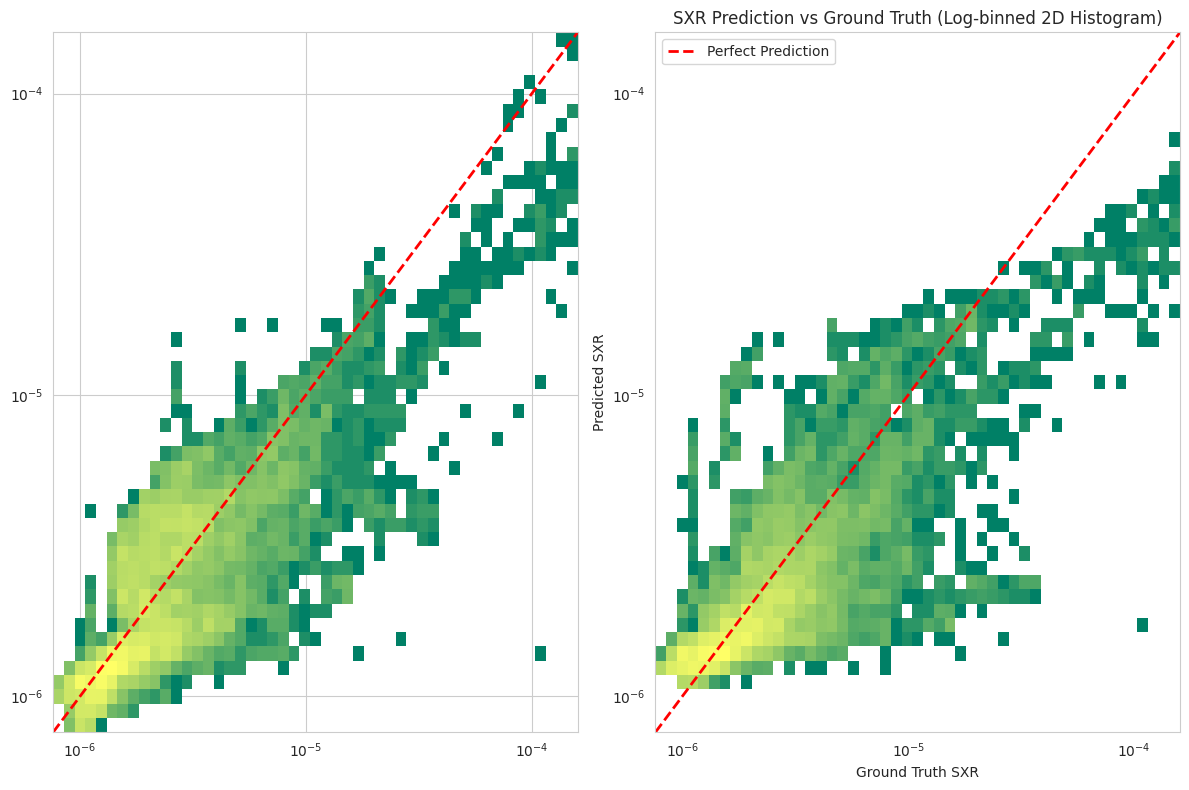

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Enhanced version with better log scale handling

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#fig.patch.set_facecolor('#1a1a2e')
#ax.set_facecolor('#2d2d44')

# Create log-spaced bins for better visualization with log scale
log_bins = np.logspace(np.log10(df2['ground_truth'].min()),
                       np.log10(df2['ground_truth'].max()), 50)

log_bins = np.logspace(np.log10(df['ground_truth'].min()),
                       np.log10(df['ground_truth'].max()), 50)

ax[0].hist2d(df['ground_truth'], df['Predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

ax[1].hist2d(df2['ground_truth'], df2['Predictions'],
           bins=[log_bins, log_bins], cmap='summer', norm='log')

#plt.colorbar(label='Count (log scale)')

# Add equality line
min_val = min(df2['ground_truth'].min(), df2['Predictions'].min())
max_val = max(df2['ground_truth'].max(), df2['Predictions'].max())
ax[0].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)
ax[1].plot([min_val, max_val], [min_val, max_val],
         label='Perfect Prediction', color='red', linestyle='--', linewidth=2,)

plt.xlabel("Ground Truth SXR")
plt.ylabel("Predicted SXR")
plt.title("SXR Prediction vs Ground Truth (Log-binned 2D Histogram)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
#plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
plt.savefig('sxr_prediction_vs_ground_truth_histogram_mixed.png', dpi=500, bbox_inches='tight',)
plt.show()

In [ ]:
df3 = pd.read_csv("/mnt/data/goes_combined/combined_g18_avg1m_20230701_20230815.csv")

In [ ]:
print(df3.head())

In [ ]:
df3['time'] = pd.to_datetime(df3['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
print(df3.head())

In [ ]:
df3 =df3[df3['quad_diode']==0]

In [ ]:
print(df3['xrsb_flux'])

In [ ]:
plt.plot(df3['time'], df3['xrsb_flux'], label='GOES XRS-B Flux', color='darkblue')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

# Set the style for dark theme with block background
plt.style.use('dark_background')
sns.set_palette("husl")

# Assuming you have your DataFrame as 'df'
# df = pd.read_csv('your_solar_data.csv')  # Load your actual data
# df['time'] = pd.to_datetime(df['time'])  # Convert time to datetime

# Create the plot with block background
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#2d2d44')

# Define colors for different XRSB flux types
colors = {
    'xrsb_flux': '#ffa726',           # Orange
    'xrsb_flux_observed': '#66bb6a',  # Green
    'xrsb_flux_electrons': '#ab47bc'  # Purple
}

# Plot XRSB data (replace with your actual df columns)
# ax.plot(df['time'], df['xrsb_flux'], color=colors['xrsb_flux'],
#         linewidth=2.5, label='XRSB Flux', alpha=0.9)
# ax.plot(df['time'], df['xrsb_flux_observed'], color=colors['xrsb_flux_observed'],
#         linewidth=2, label='XRSB Observed', alpha=0.8)
# ax.plot(df['time'], df['xrsb_flux_electrons'], color=colors['xrsb_flux_electrons'],
#         linewidth=2, label='XRSB Electrons', alpha=0.8)

# Sample data for demonstration (remove when using real data)
# 5-minute intervals for 24 hours

# Plot the data
ax.plot(df3['time'], df3['xrsb_flux'], color=colors['xrsb_flux'], label='XRS-B Flux', alpha=0.9, linewidth=4.5)

plt.yscale('log')
# Customize the plot
ax.grid(True, alpha=0.3, linestyle='--', color='white')
ax.set_ylabel('XRS-B Flux (W/m²)', fontsize=16, color='white', fontweight='bold')
ax.set_xlabel('Time', fontsize=16, color='white', fontweight='bold')
ax.set_title('GOES X-ray Flux - XRS-B Band (1-8 Angstroms)',
             fontsize=17, color='white', fontweight='bold', pad=20)


plt.xlim(pd.to_datetime("2023-07-02"), pd.to_datetime("2023-07-04"))
# # Format legend
legend = ax.legend(loc='upper right', framealpha=0.9, facecolor='#2d2d44',
                  edgecolor='white', fontsize=12)
# legend.get_frame().set_linewidth(1)

# Format ticks
ax.tick_params(axis='both', colors='white', labelsize=11)
ax.tick_params(axis='x', rotation=45)

# Format spines
# for spine in ax.spines.values():
#     spine.set_color('white')
#     spine.set_linewidth(1)



plt.tight_layout()

# Optional: Save the plot
# plt.savefig('xrsb_flux_plot.png', dpi=300, bbox_inches='tight',
#             facecolor='#1a1a2e', edgecolor='none')
plt.savefig('xrsb_flux_plot.png', dpi=500, bbox_inches='tight',
            facecolor='none', edgecolor='none')
plt.show()
